In [1]:
# ============================
# Cell 0: Install & Imports
# ============================
!pip install -q tensorflowjs

import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score,
    recall_score, f1_score, confusion_matrix
)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

pd.set_option("display.max_columns", 100)
print("TensorFlow version:", tf.__version__)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 2.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
db-dtypes 1.4.4 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
xarray 2025.11.0 requires packaging>=24.1, but you have packaging 23.2 which is incompatible.
google-cloud-bigquery 3.38.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
TensorFlow version: 2.19.0


In [2]:
# ============================
# Cell 1: Load all 3 datasets
# ============================

# Main churn dataset (with data dictionary)
xlsx_path = "E Commerce Dataset.xlsx"
df_dict = pd.read_excel(xlsx_path, sheet_name="Data Dict")
df_main = pd.read_excel(xlsx_path, sheet_name="E Comm")

# Additional churn / transactions dataset
csv_insights_path = "E Commerce Customer Insights and Churn Dataset.csv"
df_insights = pd.read_csv(csv_insights_path)

# Behavioural churn dataset
csv_user_path = "ecom-user-churn-data.csv"
df_user = pd.read_csv(csv_user_path)

print("Main E Comm dataset shape:", df_main.shape)
print("Customer Insights dataset shape:", df_insights.shape)
print("User-level churn dataset shape:", df_user.shape)

display(df_main.head())


Main E Comm dataset shape: (5630, 20)
Customer Insights dataset shape: (2000, 17)
User-level churn dataset shape: (49358, 49)


,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,50001,1,4.0,Mobile Phone,3,6.0,Debit Card,Female,3.0,3,Laptop & Accessory,2,Single,9,1,11.0,1.0,1.0,5.0,159.93
1,50002,1,NaN,Phone,1,8.0,UPI,Male,3.0,4,Mobile,3,Single,7,1,15.0,0.0,1.0,0.0,120.90
2,50003,1,NaN,Phone,1,30.0,Debit Card,Male,2.0,4,Mobile,3,Single,6,1,14.0,0.0,1.0,3.0,120.28
3,50004,1,0.0,Phone,3,15.0,Debit Card,Male,2.0,4,Laptop & Accessory,5,Single,8,0,23.0,0.0,1.0,3.0,134.07
4,50005,1,0.0,Phone,1,12.0,CC,Male,NaN,3,Mobile,5,Single,3,0,11.0,1.0,1.0,3.0,129.60


In [3]:
# =====================================
# Cell 2: Quick EDA on all 3 datasets
# =====================================

print("=== Data Dictionary (first rows) ===")
display(df_dict.head(10))

print("\n=== Main E Comm dataset info ===")
display(df_main.describe(include="all").T.head(25))

print("\nChurn value counts (main dataset):")
print(df_main["Churn"].value_counts(normalize=True))

print("\n=== Sample from Customer Insights dataset ===")
display(df_insights.head())
print("\nSubscription status distribution:")
print(df_insights["subscription_status"].value_counts())

print("\n=== Sample from User-level churn dataset ===")
display(df_user.head())
print("\nUser-level target_class distribution:")
print(df_user["target_class"].value_counts(normalize=True))


=== Data Dictionary (first rows) ===


,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3
0,NaN,Data,Variable,Discerption
1,NaN,E Comm,CustomerID,Unique customer ID
2,NaN,E Comm,Churn,Churn Flag
3,NaN,E Comm,Tenure,Tenure of customer in organization
4,NaN,E Comm,PreferredLoginDevice,Preferred login device of customer
5,NaN,E Comm,CityTier,City tier
6,NaN,E Comm,WarehouseToHome,Distance in between warehouse to home of customer
7,NaN,E Comm,PreferredPaymentMode,Preferred payment method of customer
8,NaN,E Comm,Gender,Gender of customer
9,NaN,E Comm,HourSpendOnApp,Number of hours spend on mobile application or...



=== Main E Comm dataset info ===


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
CustomerID,5630.0,NaN,NaN,NaN,52815.5,1625.385339,50001.0,51408.25,52815.5,54222.75,55630.0
Churn,5630.0,NaN,NaN,NaN,0.168384,0.37424,0.0,0.0,0.0,0.0,1.0
Tenure,5366.0,NaN,NaN,NaN,10.189899,8.557241,0.0,2.0,9.0,16.0,61.0
PreferredLoginDevice,5630,3,Mobile Phone,2765,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CityTier,5630.0,NaN,NaN,NaN,1.654707,0.915389,1.0,1.0,1.0,3.0,3.0
WarehouseToHome,5379.0,NaN,NaN,NaN,15.639896,8.531475,5.0,9.0,14.0,20.0,127.0
PreferredPaymentMode,5630,7,Debit Card,2314,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gender,5630,2,Male,3384,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HourSpendOnApp,5375.0,NaN,NaN,NaN,2.931535,0.721926,0.0,2.0,3.0,3.0,5.0
NumberOfDeviceRegistered,5630.0,NaN,NaN,NaN,3.688988,1.023999,1.0,3.0,4.0,4.0,6.0



Churn value counts (main dataset):
Churn
0    0.831616
1    0.168384
Name: proportion, dtype: float64

=== Sample from Customer Insights dataset ===


,order_id,customer_id,age,product_id,country,signup_date,last_purchase_date,cancellations_count,subscription_status,order_date,unit_price,quantity,purchase_frequency,preferred_category,product_name,category,gender
0,ORD5000,CUST1000,39,PROD200,Canada,1/7/2021,2/21/2023,0,active,8/20/2024,78.21,5,37,Sports,Football,Sports,Female
1,ORD5001,CUST1001,61,PROD201,USA,10/19/2020,12/8/2021,0,active,7/17/2025,64.02,8,35,Sports,Refrigerator,Home,Female
2,ORD5002,CUST1002,26,PROD202,Pakistan,6/10/2023,9/4/2023,3,cancelled,3/12/2025,604.14,2,44,Electronics,Hoodie,Clothing,Female
3,ORD5003,CUST1003,54,PROD203,India,7/30/2023,2/20/2024,4,paused,9/19/2024,84.66,4,1,Sports,Conditioner,Beauty,Male
4,ORD5004,CUST1004,50,PROD204,India,12/9/2020,9/14/2024,0,active,8/8/2024,62.66,7,35,Sports,Smartwatch,Electronics,Male



Subscription status distribution:
subscription_status
active       1204
cancelled     493
paused        303
Name: count, dtype: int64

=== Sample from User-level churn dataset ===


,visitorid,ses_rec,ses_rec_avg,ses_rec_sd,ses_rec_cv,user_rec,ses_n,ses_n_r,int_n,int_n_r,tran_n,tran_n_r,rev_sum,rev_sum_r,major_spend_r,int_cat_n_avg,int_itm_n_avg,ses_mo_avg,ses_mo_sd,ses_ho_avg,ses_ho_sd,ses_wknd_r,ses_len_avg,time_to_int,time_to_tran,int_cat1_n,int_cat2_n,int_cat3_n,int_cat4_n,int_cat5_n,int_cat6_n,int_cat7_n,int_cat8_n,int_cat9_n,int_cat10_n,int_cat11_n,int_cat12_n,int_cat13_n,int_cat15_n,int_cat16_n,int_cat17_n,int_cat18_n,int_cat19_n,int_cat20_n,int_cat21_n,int_cat22_n,int_cat23_n,int_cat24_n,target_class
0,89,23.0,16.0,0.0,0.0,39.0,2.0,0.051282,3.0,1.500000,0.0,0.0,0.0,0.0,0.0,1.0,1.5,7.000000,0.000000,11.000000,7.071068,0.500000,2.866667,1.911111,-1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,1
1,251,23.0,61.0,0.0,0.0,85.0,2.0,0.023529,2.0,1.000000,0.0,0.0,0.0,0.0,0.0,1.0,1.0,6.000000,1.414214,13.500000,2.121320,1.000000,0.000000,0.000000,-1.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
2,270,14.0,0.1,0.3,3.0,21.0,11.0,0.523810,13.0,1.181818,0.0,0.0,0.0,0.0,0.0,1.0,1.0,7.454546,0.522233,12.636364,4.342182,0.363636,1.104545,0.934615,-1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,0,0,1
3,298,11.0,13.0,0.0,0.0,24.0,2.0,0.083333,4.0,2.000000,0.0,0.0,0.0,0.0,0.0,1.5,1.5,7.500000,0.707107,11.500000,4.949748,0.000000,0.508333,0.254167,-1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,1,0,0,0,0,1
4,474,16.0,26.0,0.0,0.0,43.0,2.0,0.046512,2.0,1.000000,0.0,0.0,0.0,0.0,0.0,1.0,1.0,7.000000,0.000000,19.500000,2.121320,0.500000,0.000000,0.000000,-1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,1



User-level target_class distribution:
target_class
1    0.885591
0    0.114409
Name: proportion, dtype: float64


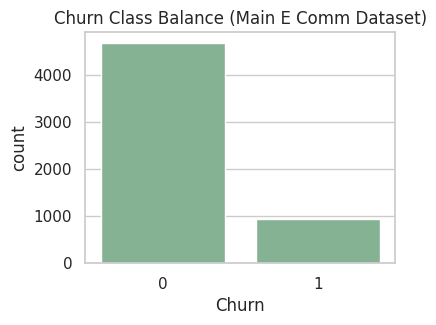

Numeric columns: ['CustomerID', 'Churn', 'Tenure', 'CityTier', 'WarehouseToHome', 'HourSpendOnApp', 'NumberOfDeviceRegistered', 'SatisfactionScore', 'NumberOfAddress', 'Complain', 'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount', 'DaySinceLastOrder', 'CashbackAmount']


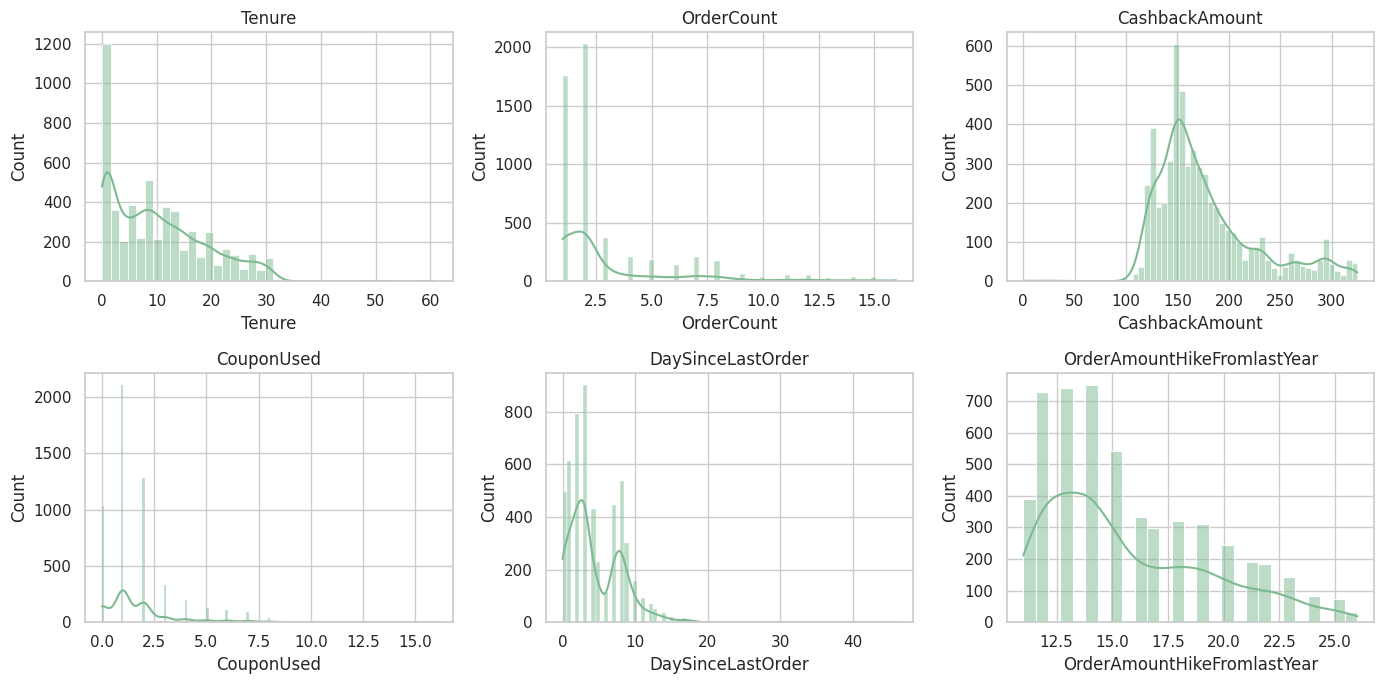

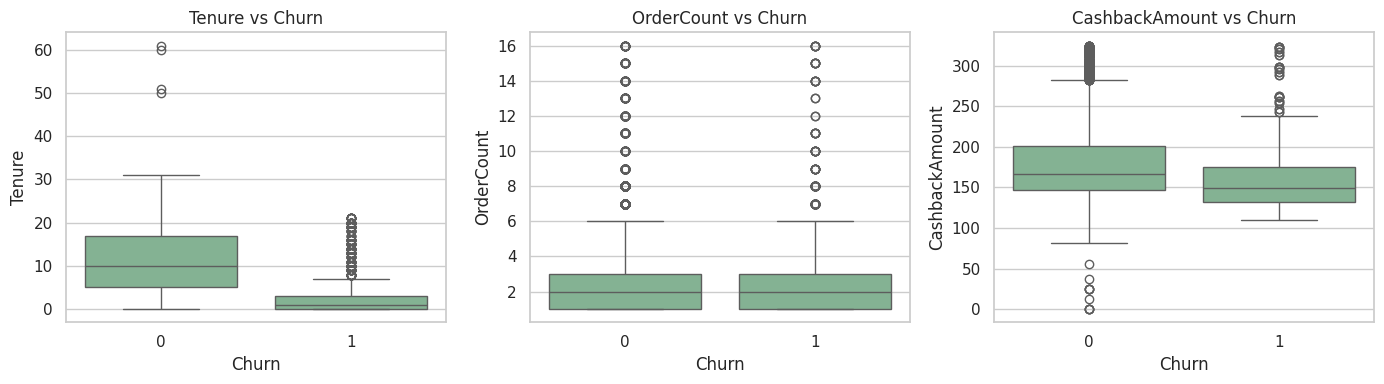

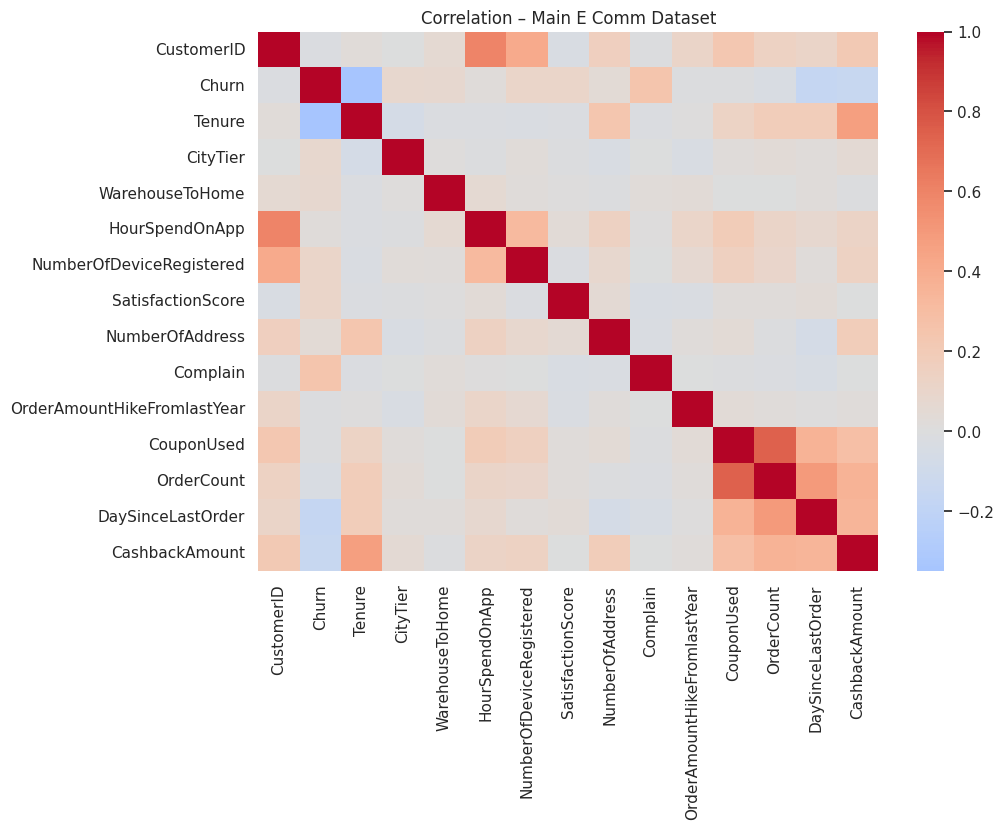

In [4]:
# ===============================================
# Cell 3: Visual EDA for main churn dataset
# ===============================================

sns.set(style="whitegrid", palette="crest")

# 1) Churn class balance
plt.figure(figsize=(4, 3))
sns.countplot(x="Churn", data=df_main)
plt.title("Churn Class Balance (Main E Comm Dataset)")
plt.show()

# 2) Numeric distributions for key features
numeric_cols_main = df_main.select_dtypes(include=[np.number]).columns.tolist()
print("Numeric columns:", numeric_cols_main)

fig, axes = plt.subplots(2, 3, figsize=(14, 7))
axes = axes.flatten()
plot_cols = ["Tenure", "OrderCount", "CashbackAmount",
             "CouponUsed", "DaySinceLastOrder", "OrderAmountHikeFromlastYear"]

for ax, col in zip(axes, plot_cols):
    if col in df_main.columns:
        sns.histplot(df_main[col], kde=True, ax=ax)
        ax.set_title(col)
    else:
        ax.set_visible(False)

plt.tight_layout()
plt.show()

# 3) Churn vs. a few important features
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

sns.boxplot(x="Churn", y="Tenure", data=df_main, ax=axes[0])
axes[0].set_title("Tenure vs Churn")

sns.boxplot(x="Churn", y="OrderCount", data=df_main, ax=axes[1])
axes[1].set_title("OrderCount vs Churn")

sns.boxplot(x="Churn", y="CashbackAmount", data=df_main, ax=axes[2])
axes[2].set_title("CashbackAmount vs Churn")

plt.tight_layout()
plt.show()

# 4) Correlation heatmap (numeric only)
corr = df_main[numeric_cols_main].corr()
plt.figure(figsize=(10, 7))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Correlation – Main E Comm Dataset")
plt.show()


In [5]:
# =======================================
# Cell 4: Feature prep & train/val split
# =======================================

ID_COL = "CustomerID"
TARGET_COL = "Churn"

# Separate target & ID
y = df_main[TARGET_COL].astype(int)
ids = df_main[ID_COL]

# Choose numeric features only (drop ID & target)
numeric_cols = df_main.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [c for c in numeric_cols if c not in [ID_COL, TARGET_COL]]
print("Numeric feature columns used:", numeric_cols)

X_numeric = df_main[numeric_cols].copy()

# Simple numeric imputation – median
for col in numeric_cols:
    median_val = X_numeric[col].median()
    X_numeric[col] = X_numeric[col].fillna(median_val)

# Train / validation split
X_train, X_val, y_train, y_val, ids_train, ids_val = train_test_split(
    X_numeric, y, ids, test_size=0.2, stratify=y, random_state=42
)

print("Train shape:", X_train.shape)
print("Val shape:", X_val.shape)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

X_train_scaled.shape, X_val_scaled.shape


Numeric feature columns used: ['Tenure', 'CityTier', 'WarehouseToHome', 'HourSpendOnApp', 'NumberOfDeviceRegistered', 'SatisfactionScore', 'NumberOfAddress', 'Complain', 'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount', 'DaySinceLastOrder', 'CashbackAmount']
Train shape: (4504, 13)
Val shape: (1126, 13)


((4504, 13), (1126, 13))

In [6]:
# =======================================
# Cell 5: Baseline – Logistic Regression
# =======================================

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_scaled, y_train)

y_val_proba_lr = log_reg.predict_proba(X_val_scaled)[:, 1]
y_val_pred_lr = (y_val_proba_lr >= 0.5).astype(int)

def print_metrics(name, y_true, y_proba, y_pred):
    auc = roc_auc_score(y_true, y_proba)
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    print(f"\n{name}")
    print("-" * len(name))
    print(f"AUC  : {auc:.4f}")
    print(f"ACC  : {acc:.4f}")
    print(f"PREC : {prec:.4f}")
    print(f"REC  : {rec:.4f}")
    print(f"F1   : {f1:.4f}")

print_metrics("Logistic Regression (validation)", y_val, y_val_proba_lr, y_val_pred_lr)



Logistic Regression (validation)
--------------------------------
AUC  : 0.8461
ACC  : 0.8694
PREC : 0.6937
REC  : 0.4053
F1   : 0.5116


Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - accuracy: 0.7354 - auc: 0.5416 - loss: 0.5579 - val_accuracy: 0.7798 - val_auc: 0.5715 - val_loss: 0.5250
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7827 - auc: 0.5919 - loss: 0.5086 - val_accuracy: 0.8082 - val_auc: 0.6221 - val_loss: 0.4852
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.8102 - auc: 0.6421 - loss: 0.4707 - val_accuracy: 0.8233 - val_auc: 0.6672 - val_loss: 0.4556
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8300 - auc: 0.6880 - loss: 0.4416 - val_accuracy: 0.8339 - val_auc: 0.7054 - val_loss: 0.4334
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8383 - auc: 0.7267 - loss: 0.4190 - val_accuracy: 0.8375 - val_auc: 0.7371 - val_loss: 0.4162
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.8433 - auc: 0.7573 - loss: 0.4010 - val_accuracy: 0.8419 - val_auc: 0.7604 - val_loss: 0.4026
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/

<Figure size 600x400 with 0 Axes>

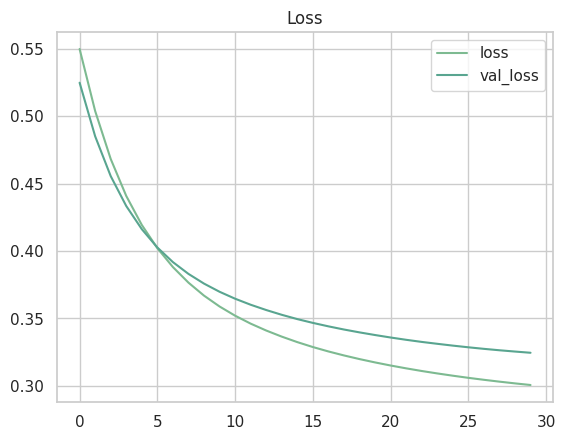

<Figure size 600x400 with 0 Axes>

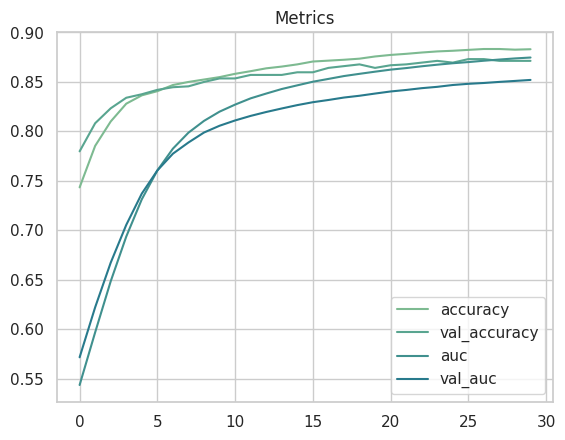

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Shallow NN (validation)
-----------------------
AUC  : 0.8521
ACC  : 0.8712
PREC : 0.7027
REC  : 0.4105
F1   : 0.5183

Confusion Matrix (val):
[[903  33]
 [112  78]]


In [7]:
# =======================================
# Cell 6: Shallow NN – Keras
# =======================================

tf.random.set_seed(42)

model = keras.Sequential([
    layers.Input(shape=(X_train_scaled.shape[1],)),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid"),
])

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=[
        "accuracy",
        keras.metrics.AUC(name="auc")
    ]
)

history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=30,
    batch_size=256,
    verbose=1
)

# Plot training curves
history_df = pd.DataFrame(history.history)

plt.figure(figsize=(6, 4))
history_df[["loss", "val_loss"]].plot()
plt.title("Loss")
plt.show()

plt.figure(figsize=(6, 4))
history_df[["accuracy", "val_accuracy", "auc", "val_auc"]].plot()
plt.title("Metrics")
plt.show()

# Evaluate on validation set
y_val_proba_nn = model.predict(X_val_scaled).ravel()
y_val_pred_nn = (y_val_proba_nn >= 0.5).astype(int)

print_metrics("Shallow NN (validation)", y_val, y_val_proba_nn, y_val_pred_nn)

cm = confusion_matrix(y_val, y_val_pred_nn)
print("\nConfusion Matrix (val):")
print(cm)


Customer Insights – churn rate: 0.2465


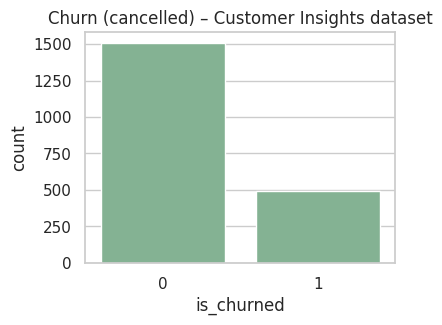

User-level churn rate (target_class=1): 0.885590988289639


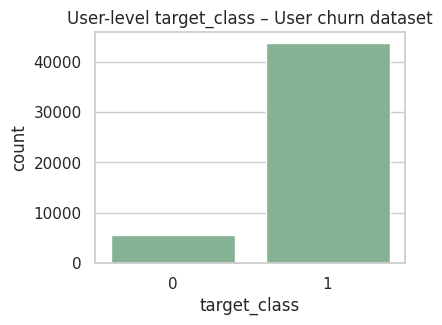

In [8]:
# ====================================================
# Cell 7: Extra EDA on Insights + User-level datasets
# ====================================================

# Customer insights churn: define a basic flag (cancelled vs others)
df_insights["is_churned"] = (df_insights["subscription_status"].str.lower() == "cancelled").astype(int)
print("Customer Insights – churn rate:",
      df_insights["is_churned"].mean())

plt.figure(figsize=(4, 3))
sns.countplot(x="is_churned", data=df_insights)
plt.title("Churn (cancelled) – Customer Insights dataset")
plt.show()

# User-level churn
print("User-level churn rate (target_class=1):",
      df_user["target_class"].mean())

plt.figure(figsize=(4, 3))
sns.countplot(x="target_class", data=df_user)
plt.title("User-level target_class – User churn dataset")
plt.show()

In [9]:
# ===================================================
# Cell 8: Prepare sample train & scoring CSVs
# ===================================================

train_web = df_main.copy()
scoring_web = df_main.drop(columns=[TARGET_COL]).copy()

train_web_path = "train_web.csv"
scoring_web_path = "scoring_web.csv"

train_web.to_csv(train_web_path, index=False)
scoring_web.to_csv(scoring_web_path, index=False)

print("Saved:", train_web_path, "and", scoring_web_path)


Saved: train_web.csv and scoring_web.csv


In [10]:
# ===================================================
# Cell 9: Export preprocessing config for TF.js app
# ===================================================

os.makedirs("config", exist_ok=True)

numeric_means = scaler.mean_
numeric_stds = scaler.scale_

preprocessing_config = {
    "target": TARGET_COL,
    "id_col": ID_COL,
    "numeric_cols": numeric_cols,
    "numeric_means": dict(zip(numeric_cols, numeric_means)),
    "numeric_stds": dict(zip(numeric_cols, numeric_stds)),
}

config_path = "config/preprocessing_config.json"
with open(config_path, "w") as f:
    json.dump(preprocessing_config, f, indent=2)

print("Wrote preprocessing config to", config_path)
preprocessing_config


Wrote preprocessing config to config/preprocessing_config.json


{'target': 'Churn',
 'id_col': 'CustomerID',
 'numeric_cols': ['Tenure',
  'CityTier',
  'WarehouseToHome',
  'HourSpendOnApp',
  'NumberOfDeviceRegistered',
  'SatisfactionScore',
  'NumberOfAddress',
  'Complain',
  'OrderAmountHikeFromlastYear',
  'CouponUsed',
  'OrderCount',
  'DaySinceLastOrder',
  'CashbackAmount'],
 'numeric_means': {'Tenure': np.float64(10.130328596802842),
  'CityTier': np.float64(1.6649644760213145),
  'WarehouseToHome': np.float64(15.642317939609237),
  'HourSpendOnApp': np.float64(2.935612788632327),
  'NumberOfDeviceRegistered': np.float64(3.6962699822380105),
  'SatisfactionScore': np.float64(3.0672735346358793),
  'NumberOfAddress': np.float64(4.197380106571936),
  'Complain': np.float64(0.2801953818827709),
  'OrderAmountHikeFromlastYear': np.float64(15.683836589698046),
  'CouponUsed': np.float64(1.7184724689165187),
  'OrderCount': np.float64(2.924511545293073),
  'DaySinceLastOrder': np.float64(4.4560390763765545),
  'CashbackAmount': np.float64(177

In [11]:
# ===================================================
# Cell 10: Convert Keras model -> TF.js format
# ===================================================

import tensorflowjs as tfjs

os.makedirs("model", exist_ok=True)
tfjs.converters.save_keras_model(model, "model")

!ls -R


failed to lookup keras version from the file,
    this is likely a weight only file
.:
 config						       model
'E Commerce Customer Insights and Churn Dataset.csv'   sample_data
'E Commerce Dataset.xlsx'			       scoring_web.csv
 ecom-user-churn-data.csv			       train_web.csv

./config:
preprocessing_config.json

./model:
group1-shard1of1.bin  model.json

./sample_data:
anscombe.json		      mnist_test.csv
california_housing_test.csv   mnist_train_small.csv
california_housing_train.csv  README.md


In [12]:
# ===================================================
# Cell 11: Create deployment bundle for GitHub
# ===================================================

from google.colab import files
import shutil

bundle_dir = "deployment_bundle"
os.makedirs(bundle_dir, exist_ok=True)

# Copy folders/files into bundle dir
if os.path.exists("model"):
    shutil.copytree("model", os.path.join(bundle_dir, "model"), dirs_exist_ok=True)
if os.path.exists("config"):
    shutil.copytree("config", os.path.join(bundle_dir, "config"), dirs_exist_ok=True)

shutil.copy("train_web.csv", os.path.join(bundle_dir, "train_web.csv"))
shutil.copy("scoring_web.csv", os.path.join(bundle_dir, "scoring_web.csv"))

zip_name = "deployment_bundle.zip"
shutil.make_archive("deployment_bundle", "zip", bundle_dir)

print("Created bundle:", zip_name)
files.download(zip_name)


Created bundle: deployment_bundle.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>